In [1]:
import builtins
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Output path
output_path = '../export/simulators/pro_risk_friendly_trader/'

In [3]:
# Run the input processing notebook to prepare input
%run "../helpers/data-processing.ipynb"

Missing values in the dataset


,Column,Missing Count,Missing Percentage,Action
0,date,0,0.000000,No Missing Values
1,open,0,0.000000,No Missing Values
2,high,0,0.000000,No Missing Values
3,low,0,0.000000,No Missing Values
4,close,0,0.000000,No Missing Values
5,Volume USDT,0,0.000000,No Missing Values
6,tradecount,0,0.000000,No Missing Values
7,ema_5,0,0.000000,No Missing Values
8,ema_15,0,0.000000,No Missing Values
9,ema_30,0,0.000000,No Missing Values


Analyzing feature correlations...

The following features were dropped due to high correlation (threshold: 90%):
- low
- ema_60
- ema_100
- ema_200
- ema_15
- ema_5
- MACD_Hist
- ema_30
- WMA
- high
- HMA
- open
- KAMA
- Z-Score
- close

Performing feature selection using RandomForestClassifier...

Cross-validation accuracy scores: [0.99988 0.99982 1.     ]

Mean accuracy: 0.9999

The following features were selected based on feature importance:
- date
- price
- Volume USDT
- tradecount
- MACD
- MACD_Signal
- ATR
- CMO
- QStick
- price_change_ratio
- high_low_spread

Feature selection process completed.

Shape of X: (1997210, 11)


,date,price,Volume USDT,tradecount,MACD,MACD_Signal,ATR,CMO,QStick,price_change_ratio,high_low_spread
0,1.577837e+09,7180.720,509146.0,140.0,0.728704,-0.152219,4.684925,4.193879,0.120,0.000000,3.69
1,1.577837e+09,7178.470,713540.0,148.0,0.736887,-0.182091,4.698380,0.859360,0.528,-0.000313,3.76
2,1.577837e+09,7179.440,497793.0,104.0,0.846578,-0.117923,4.609025,11.466626,0.493,0.000135,5.60
3,1.577837e+09,7177.175,698627.0,193.0,0.650488,-0.343494,4.398181,-7.962104,-0.425,-0.000315,6.16
4,1.577837e+09,7175.160,241980.0,124.0,0.987398,-0.092457,4.262656,-6.795307,-0.131,-0.000281,3.86
...,...,...,...,...,...,...,...,...,...,...,...
1997205,1.698019e+09,29966.285,482950.0,635.0,-4056.925846,-1909.922487,926.278065,-97.689989,13.189,-0.000401,5.00
1997206,1.698019e+09,29970.500,169682.0,450.0,-3657.565528,-1988.042791,996.882531,-97.688910,24.399,0.000141,5.83
1997207,1.698019e+09,29975.100,111271.0,303.0,-3095.229187,-1922.717147,1072.856572,-97.688328,32.045,0.000153,3.40
1997208,1.698019e+09,29980.890,169741.0,631.0,-2332.807178,-1640.974425,1154.492462,-97.687019,22.669,0.000193,8.21



Shape of y: (1997210,)


0    1
1    0
2    1
3    0
4    0
Name: price_direction, dtype: int64

In [4]:
# Ensure the features and target align
prices = features['price'].values   # Price column
predictions = target.values        # Binary predictions from target

In [5]:
# Parameters
rolling_window = 30  # Moderate rolling window
train_window = 60  # Training window for decision tree
buy_fee = 0.0025  # 0.25% buy fee
sell_fee = 0.004  # 0.40% sell fee
risk_factor = 0.5  # Aggressiveness factor
profit_threshold = 0.0005  # Minimum profit term to act
max_trade_percentage = 0.3  # Max 30% per trade

In [6]:
# Portfolio Initialization
initial_capital = 10000.0  # Starting capital in USD
usd_balance = initial_capital
btc_balance = 0.0

In [7]:
# Tracking Variables
usd_balances = []
btc_balances = []
actions = []
trade_percentages = []

In [8]:
# Indicators to consider
indicators = ['price_change_ratio', 'Volume USDT', 'tradecount', 'MACD', 'ATR', 'CMO', 'high_low_spread']

# Initialize Scaler and Model
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
scaler = MinMaxScaler()

In [9]:
# Calculate Rolling Metrics
rolling_returns = pd.Series(prices).pct_change().rolling(rolling_window).mean().fillna(0).values
rolling_volatility = pd.Series(prices).pct_change().rolling(rolling_window).std().fillna(0).values

In [10]:
# Simulate Trading with Adjusted Risk-Friendly Logic
for t in tqdm(range(len(prices)), desc="Processing Rows", unit="rows"):
    action = 'None'
    trade_percentage = 0.0

    if t < max(rolling_window, train_window):
        usd_balances.append(usd_balance)
        btc_balances.append(btc_balance)
        actions.append(action)
        trade_percentages.append(trade_percentage)
        continue

    # Rolling metrics
    expected_return = rolling_returns[t]
    volatility = rolling_volatility[t]
    reward_to_risk_ratio = (expected_return / (volatility + 1e-6)) if volatility > 0 else 0
    dynamic_threshold = max(profit_threshold, volatility * 0.5)
    profit_term = expected_return * (1 + risk_factor * reward_to_risk_ratio)

    # Prepare training input_data
    train_data = features.iloc[t - train_window:t][indicators].values
    train_target = target.iloc[t - train_window:t].values
    scaled_train_data = scaler.fit_transform(train_data)
    tree_model.fit(scaled_train_data, train_target)

    # Predict action
    current_data = features.iloc[[t]][indicators].values
    scaled_current_data = scaler.transform(current_data)
    predicted_action = tree_model.predict(scaled_current_data)[0]
    predicted_proba = tree_model.predict_proba(scaled_current_data)
    buy_proba, sell_proba = (
        predicted_proba[0][1] if predicted_proba.shape[1] > 1 else 0.0,
        predicted_proba[0][0] if predicted_proba.shape[1] > 1 else 1.0,
    )

    # Trade logic
    if predicted_action == 1 and usd_balance > 1e-3 and profit_term > dynamic_threshold:
        trade_percentage = min(max_trade_percentage * buy_proba, usd_balance / prices[t])
        usd_spent = trade_percentage * usd_balance
        btc_bought = (usd_spent * (1 - buy_fee)) / prices[t]
        usd_balance -= usd_spent
        btc_balance += btc_bought
        action = 'Buy'

    elif predicted_action == 0 and btc_balance > 1e-6 and profit_term < -dynamic_threshold:
        trade_percentage = min(max_trade_percentage * sell_proba, btc_balance)
        btc_to_sell = trade_percentage * btc_balance
        usd_gained = btc_to_sell * prices[t] * (1 - sell_fee)
        btc_balance -= btc_to_sell
        usd_balance += usd_gained
        action = 'Sell'

    # Record results
    usd_balances.append(usd_balance)
    btc_balances.append(btc_balance)
    actions.append(action)
    trade_percentages.append(trade_percentage)

Processing Rows: 100%|██████████| 1997210/1997210 [36:39<00:00, 908.01rows/s]


In [11]:
# Ensure Lengths Match
assert len(usd_balances) == len(prices), "USD balances length mismatch!"
assert len(btc_balances) == len(prices), "BTC balances length mismatch!"
assert len(actions) == len(prices), "Actions length mismatch!"
assert len(trade_percentages) == len(prices), "Trade percentages length mismatch!"

In [12]:
# Export Results to a DataFrame
builtins.data = risk_tolerant_trader_df = pd.DataFrame({
    'prices': prices,
    'USD_Balance': usd_balances,
    'BTC_Balance': btc_balances,
    'Action': actions,
    'Trade_Percentage': trade_percentages,
    'Rolling_Returns': rolling_returns,
    'Rolling_Volatility': rolling_volatility,
})

Trading Log:


,prices,USD_Balance,BTC_Balance,Action,Trade_Percentage,Rolling_Returns,Rolling_Volatility,Total_Capital
0,7180.720,10000.000000,0.000000,None,0.0,0.000000,0.000000,10000.000000
1,7178.470,10000.000000,0.000000,None,0.0,0.000000,0.000000,10000.000000
2,7179.440,10000.000000,0.000000,None,0.0,0.000000,0.000000,10000.000000
3,7177.175,10000.000000,0.000000,None,0.0,0.000000,0.000000,10000.000000
4,7175.160,10000.000000,0.000000,None,0.0,0.000000,0.000000,10000.000000
...,...,...,...,...,...,...,...,...
1997205,29966.285,86.432992,1.373836,None,0.0,0.000024,0.000267,41255.191841
1997206,29970.500,86.432992,1.373836,None,0.0,0.000043,0.000252,41260.982560
1997207,29975.100,86.432992,1.373836,None,0.0,0.000039,0.000250,41267.302205
1997208,29980.890,86.432992,1.373836,None,0.0,0.000034,0.000244,41275.256715


Processing Rows: 100%|██████████| 1997210/1997210 [00:38<00:00, 51457.48rows/s]


Final Portfolio Status:
  USD Balance: $86.43
  BTC Balance: 1.373836 BTC
  BTC Value (in USD at last price): $41199.59
  Total Portfolio Value (USD): $41286.03
  Profit/Loss: 312.86%
  Total Trades Executed: 11170
    Buy Trades: 11164
    Sell Trades: 6


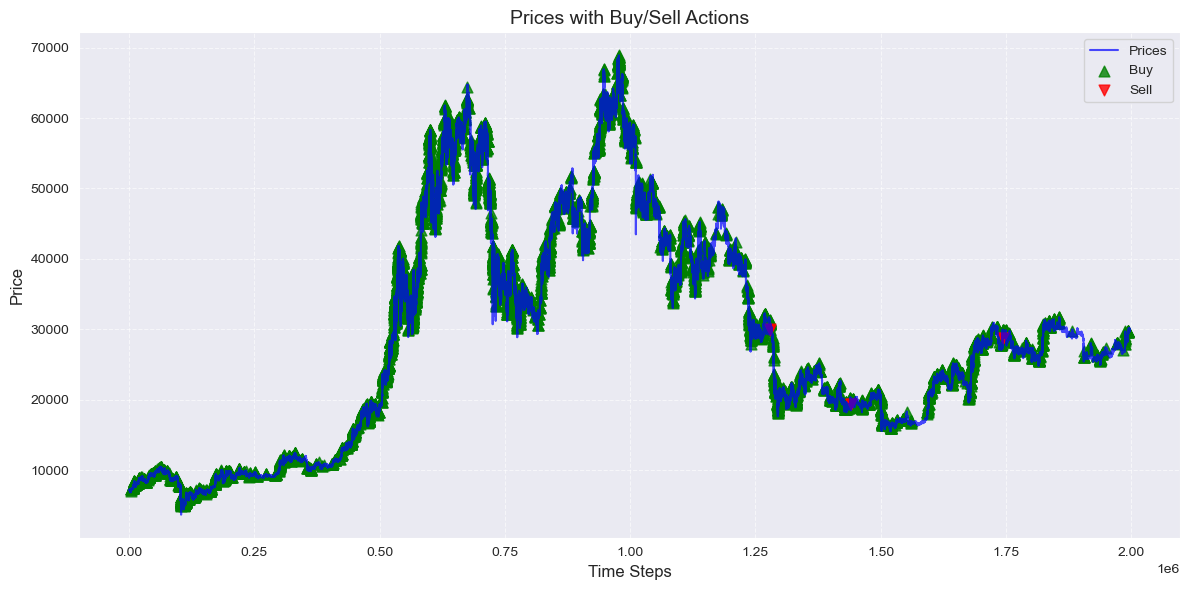

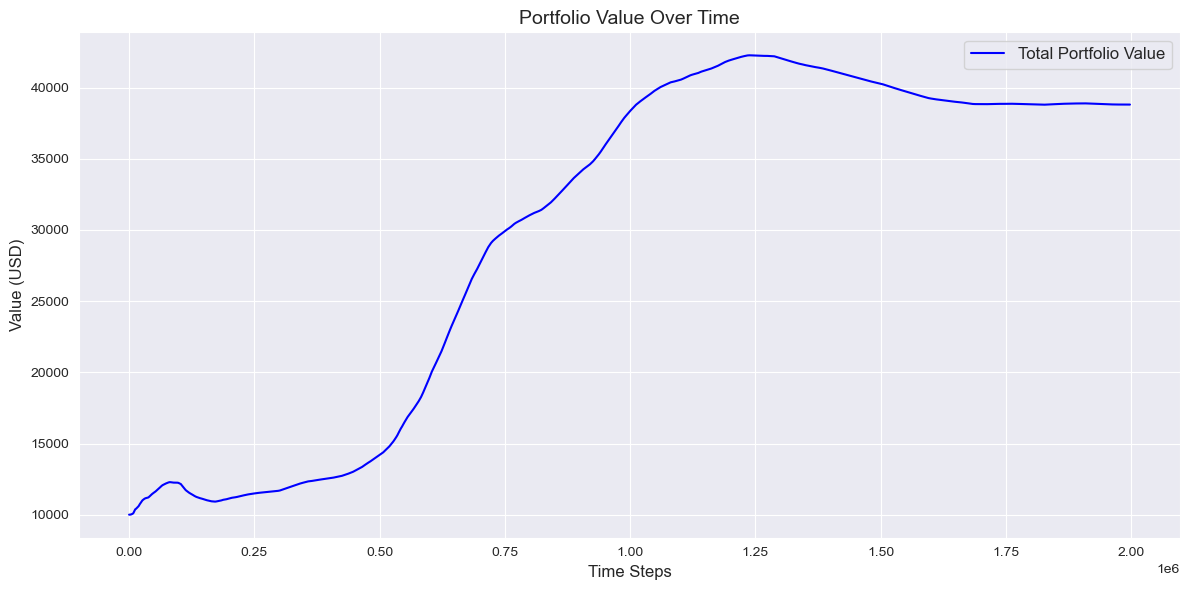

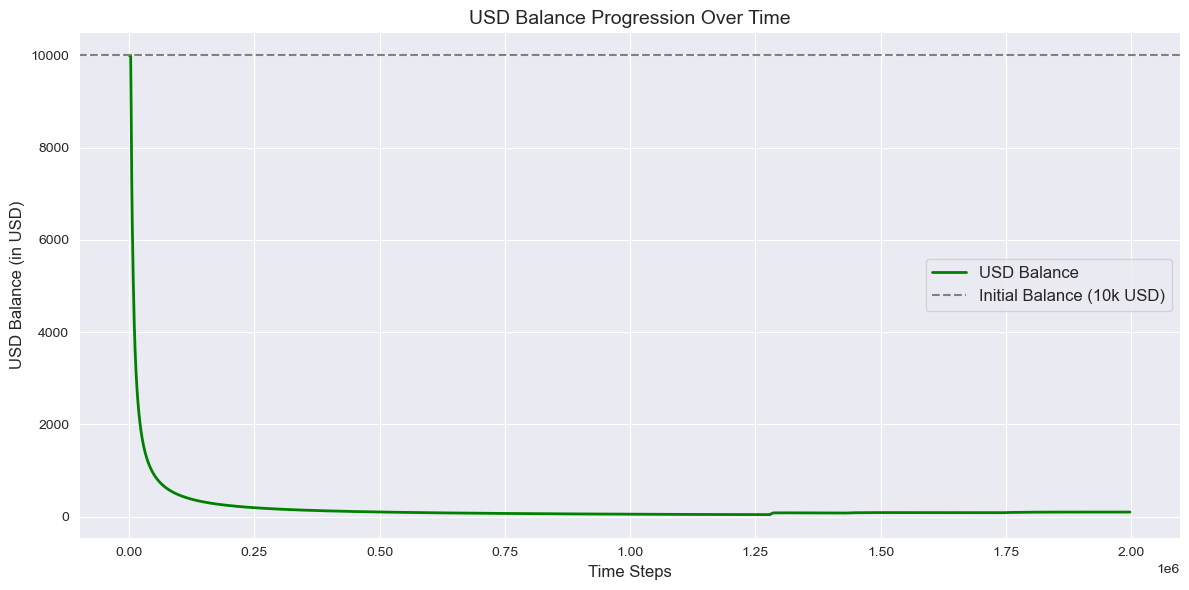

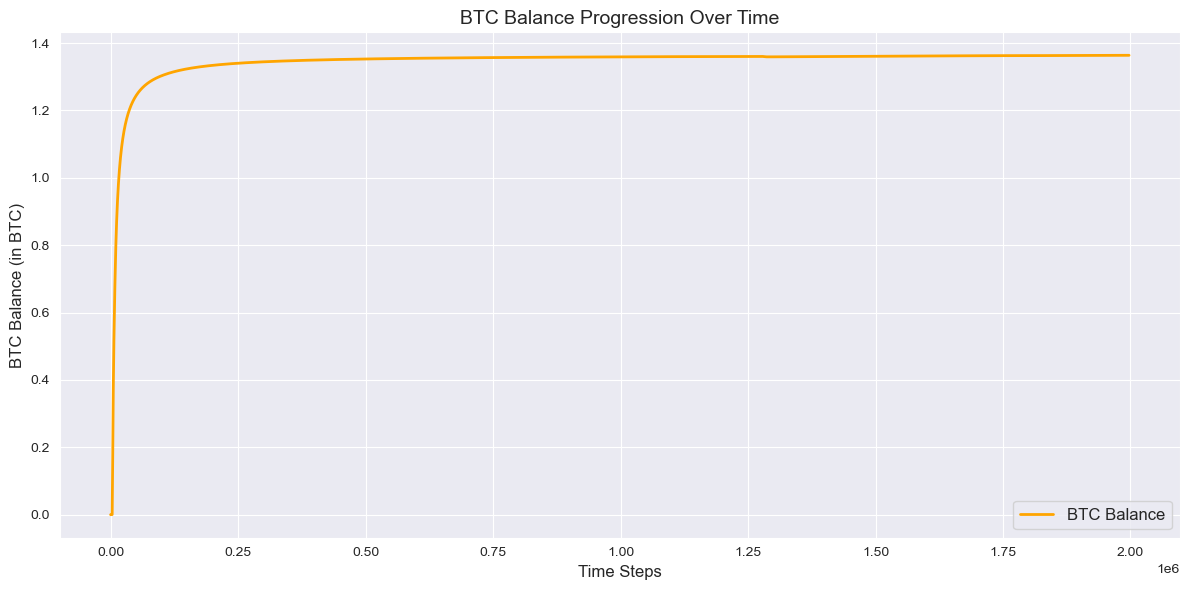

In [14]:
%run "../helpers/trades.ipynb"

Data Leakage Check

Data alignment check passed.
Correlation between predictions and future price changes:
                     predictions  future_price_change
predictions             1.000000             0.250137
future_price_change     0.250137             1.000000


Feature Importance Analysis

Feature Importances:
               Feature  Importance
9   price_change_ratio    0.941433
8               QStick    0.022292
7                  CMO    0.009655
5          MACD_Signal    0.008473
10     high_low_spread    0.005913
6                  ATR    0.002730
4                 MACD    0.002276
2          Volume USDT    0.002252
3           tradecount    0.001853
0                 date    0.001638
1                price    0.001486
Permutation Importances:
               Feature  Importance
9   price_change_ratio    0.499862
8               QStick    0.000049
7                  CMO    0.000046
5          MACD_Signal    0.000040
10     high_low_spread    0.000036
4                 MACD  

Processing Rows: 100%|██████████| 1997210/1997210 [00:38<00:00, 52243.72rows/s]




Sensitivity Analysis



,Initial USD Balance,Initial BTC Balance,Maker Fee,Taker Fee,Final USD Balance,Final BTC Balance,Total Portfolio Value (USD),Profit/Loss (%),Buy Trades,Sell Trades
0,10000.0,0.0,0.0025,0.0040,86.432992,1.373836,41286.027589,312.860276,11164,6
1,10000.0,0.0,0.0015,0.0030,86.784586,1.379448,41454.664452,314.546645,11164,6
2,10000.0,0.0,0.0050,0.0075,85.385500,1.357809,40804.357418,308.043574,11164,6
3,20000.0,0.0,0.0025,0.0040,172.865983,2.747672,82572.055177,312.860276,11164,6
4,20000.0,0.0,0.0015,0.0030,173.569172,2.758895,82909.328905,314.546645,11164,6
5,20000.0,0.0,0.0050,0.0075,170.771000,2.715618,81608.714835,308.043574,11164,6
6,5000.0,0.5,0.0025,0.0040,74.862251,1.189921,35759.088086,615.181762,11164,6
7,5000.0,0.5,0.0015,0.0030,75.134957,1.194276,35889.949975,617.798999,11164,6
8,5000.0,0.5,0.0050,0.0075,74.033529,1.177289,35379.432945,607.588659,11164,6


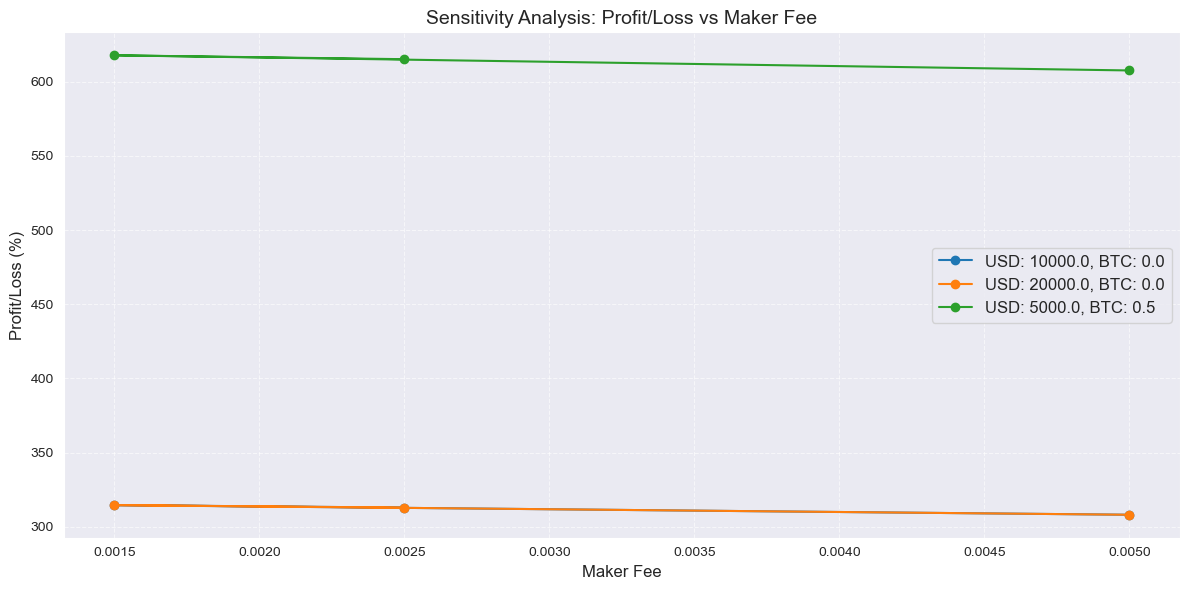

In [15]:
%run "../helpers/testing.ipynb"